In [52]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

In [34]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
hdu_list.close()

#print(hdr)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.025603  -0.055354  
CRPIX : 707.984856  349.128859  
CD1_1 CD1_2  : -2.69158778194532e-05  -0.000164482292120484  
CD2_1 CD2_2  : -0.000164482292120484  2.69158778194532e-05  
NAXIS : 1415  697
[[ 2.29044474e+02  1.02923422e-02]
 [ 2.28999316e+02 -7.65101310e-03]
 [ 2.29044623e+02 -4.03981082e-02]]


In [6]:
filename_ap = 'outputs/apphot_test01.txt'
filename_psf = 'outputs/psf_test01.txt'

file_ap = pd.read_csv(filename_ap, sep=',')
file_psf = pd.read_csv(filename_psf, sep=',')
print(file_ap['apparent_mag_median'])
print(file_psf)

#plt.plot(file_ap['apparent_mag_median'], file_psf['apparent_mag'][:1036])

0             NaN
1             NaN
2       18.336073
3             NaN
4       17.454892
          ...    
1031    17.037974
1032          NaN
1033    15.627514
1034          NaN
1035          NaN
Name: apparent_mag_median, Length: 1036, dtype: float64
        id          x_0         y_0  apparent_mag
0        1   963.985960   20.261938           NaN
1        2  1392.974900   21.632072           NaN
2       11  1385.345100   28.346766     16.701163
3        3  1212.495100   23.557976     17.631307
4        4  1291.027400   23.950220     16.113888
...    ...          ...         ...           ...
1540  1533   433.761790  672.580930     15.637303
1541  1536   197.317130  674.782820           NaN
1542  1538   218.184010  675.621250           NaN
1543  1539   556.983370  675.728950           NaN
1544  1545    99.873038  680.125240     14.503166

[1545 rows x 4 columns]


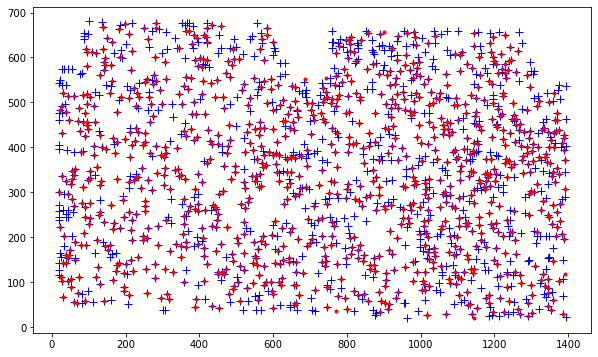

In [21]:
x_ap = file_ap['xcenter']
y_ap = file_ap['ycenter']
x_psf = file_psf['x_0']
y_psf = file_psf['y_0']

plt.plot(x_psf, y_psf, 'b+', lw=0.15, markersize=8)
plt.plot(x_ap, y_ap, 'r.')
plt.gcf().set_size_inches(10, 6)

In [28]:
#coords_ap = SkyCoord(ra = x_ap, dec = y_ap)

In [46]:
w = wcs.WCS(hdr)
print(w)
#w.wcs.print_contents()

crd_ap = np.transpose((x_ap, y_ap))
crd_psf = np.transpose((x_psf, y_psf))
world_ap = w.wcs_pix2world(crd_ap, 0)
world_psf = w.wcs_pix2world(crd_psf, 0)

#print(world_ap, world_psf)

ra_ap = world_ap[:,0]
dec_ap = world_ap[:,1]
ra_psf = world_psf[:,0]
dec_psf = world_psf[:,1]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.025603  -0.055354  
CRPIX : 707.984856  349.128859  
CD1_1 CD1_2  : -2.69158778194532e-05  -0.000164482292120484  
CD2_1 CD2_2  : -0.000164482292120484  2.69158778194532e-05  
NAXIS : 1415  697


In [58]:
c_ap = SkyCoord(ra_ap, dec_ap, frame='icrs', unit='deg')
c_psf = SkyCoord(ra_psf, dec_psf, frame='icrs', unit='deg')
print(len(c_ap), len(c_psf))

idx, d2d, d3d = c_psf.match_to_catalog_sky(c_ap)
print(idx, d2d, d3d)
print(len(idx))

idx2, sep2d, dist3d = match_coordinates_sky(c_psf, c_ap)
print(idx2, sep2d, dist3d)
print(len(idx2))

1036 1545
[   2    5    5 ... 1034 1030 1031] [0d00m32.0799s 0d00m06.0983s 0d00m00s ... 0d00m12.5304s 0d00m16.5387s
 0d00m24.2208s] [1.55527597e-04 2.95654828e-05 0.00000000e+00 ... 6.07493337e-05
 8.01818596e-05 1.17425510e-04]
1545
[   2    5    5 ... 1034 1030 1031] [0d00m32.0799s 0d00m06.0983s 0d00m00s ... 0d00m12.5304s 0d00m16.5387s
 0d00m24.2208s] [1.55527597e-04 2.95654828e-05 0.00000000e+00 ... 6.07493337e-05
 8.01818596e-05 1.17425510e-04]
1545


In [62]:
radius = 0.4/3600.
selection = (d2d > radius*u.deg)
match_index = idx
match_index[selection] = -99.
s2 = (match_index >= 0)


array([False, False,  True, ..., False, False, False])

with 0.6x0.6 arcsec pixels, 6 pix (i.e. aperture radius) = 3.6 arcsec = 0.001 deg:

In [65]:
x = 3.6 * u.arcsec
x.to(u.deg)

<Quantity 0.001 deg>

In [73]:
#max_sep = 0.001 * u.deg
max_sep = 3.6 * u.arcsec
constraint = d2d < max_sep
c_psf_matches = c_psf[constraint]
c_ap_matches = c_ap[idx[constraint]]

print(len(c_psf_matches))
print(len(c_ap_matches))
print(c_psf_matches)
print(c_ap_matches)

1051
1051
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05994291, -0.17553926), (229.06320471, -0.16014406),
     (229.06420603, -0.14423273), ..., (228.97953582, -0.00562422),
     (228.97959045, -0.00168075), (228.98559241,  0.0372694 )]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05994291, -0.17553926), (229.06320471, -0.16014406),
     (229.06420603, -0.14423273), ..., (228.97953582, -0.00562422),
     (228.97959045, -0.00168075), (228.98559241,  0.0372694 )]>


# this might be working????? i do not know???????

ValueError: setting an array element with a sequence.

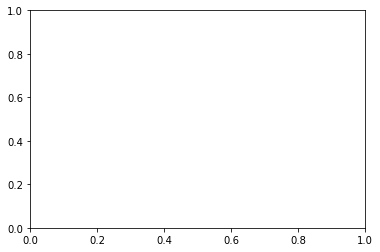

In [70]:
plt.plot(c_psf_matches)